# Linear regression project - predicting the sale price of homes

# Data exploration and feature design

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import h2o

In [3]:
# read in training and test data
housing_train = pd.read_csv('../data/processed/train_clean.csv', index_col = 'Id', keep_default_na = False)
housing_test = pd.read_csv('../data/processed/test_clean.csv', index_col = 'Id', keep_default_na = False)

## 1. Exploration of target variable

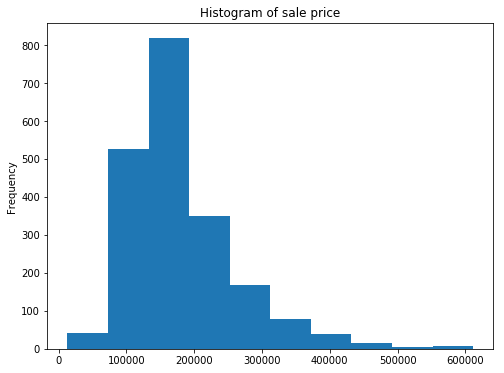

In [4]:
fig, ax = plt.subplots(figsize=(8,6))
housing_train['SalePrice'].plot(kind='hist', ax=ax)
ax.set_title('Histogram of sale price');

In [5]:
## Target variable is right skewed, whereas we want a normally distributed target for linear regression

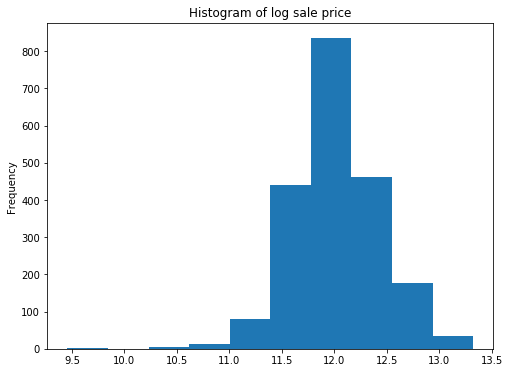

In [6]:
# log transform price to get a more normally distributed target
housing_train['Log Price'] = np.log(housing_train['SalePrice'])

fig, ax = plt.subplots(figsize=(8,6))
housing_train['Log Price'].plot(kind='hist', ax=ax)
ax.set_title('Histogram of log sale price');

## 2. Exploration of features

### Scatter plots

In [7]:
housing_train.shape

(2051, 81)

In [8]:
def scatter_plot(x,y,ax):
    ax.scatter(housing_train[x], housing_train[y], alpha=0.2)
    ax.set_title(y+' by '+x)
    try:
        ax.plot(np.unique(housing_train[x]), np.poly1d(np.polyfit(housing_train[x], housing_train[y], 1))(np.unique(housing_train[x])))
        correlation = round(np.corrcoef(housing_train[x], housing_train[y])[0,1],2)
        ax.annotate('Corr:'+str(correlation),xy=(housing_train[x].min(),housing_train[y].max()))
    except:
        pass
    ax.set_ylabel(y)
    ax.set_xlabel(x)

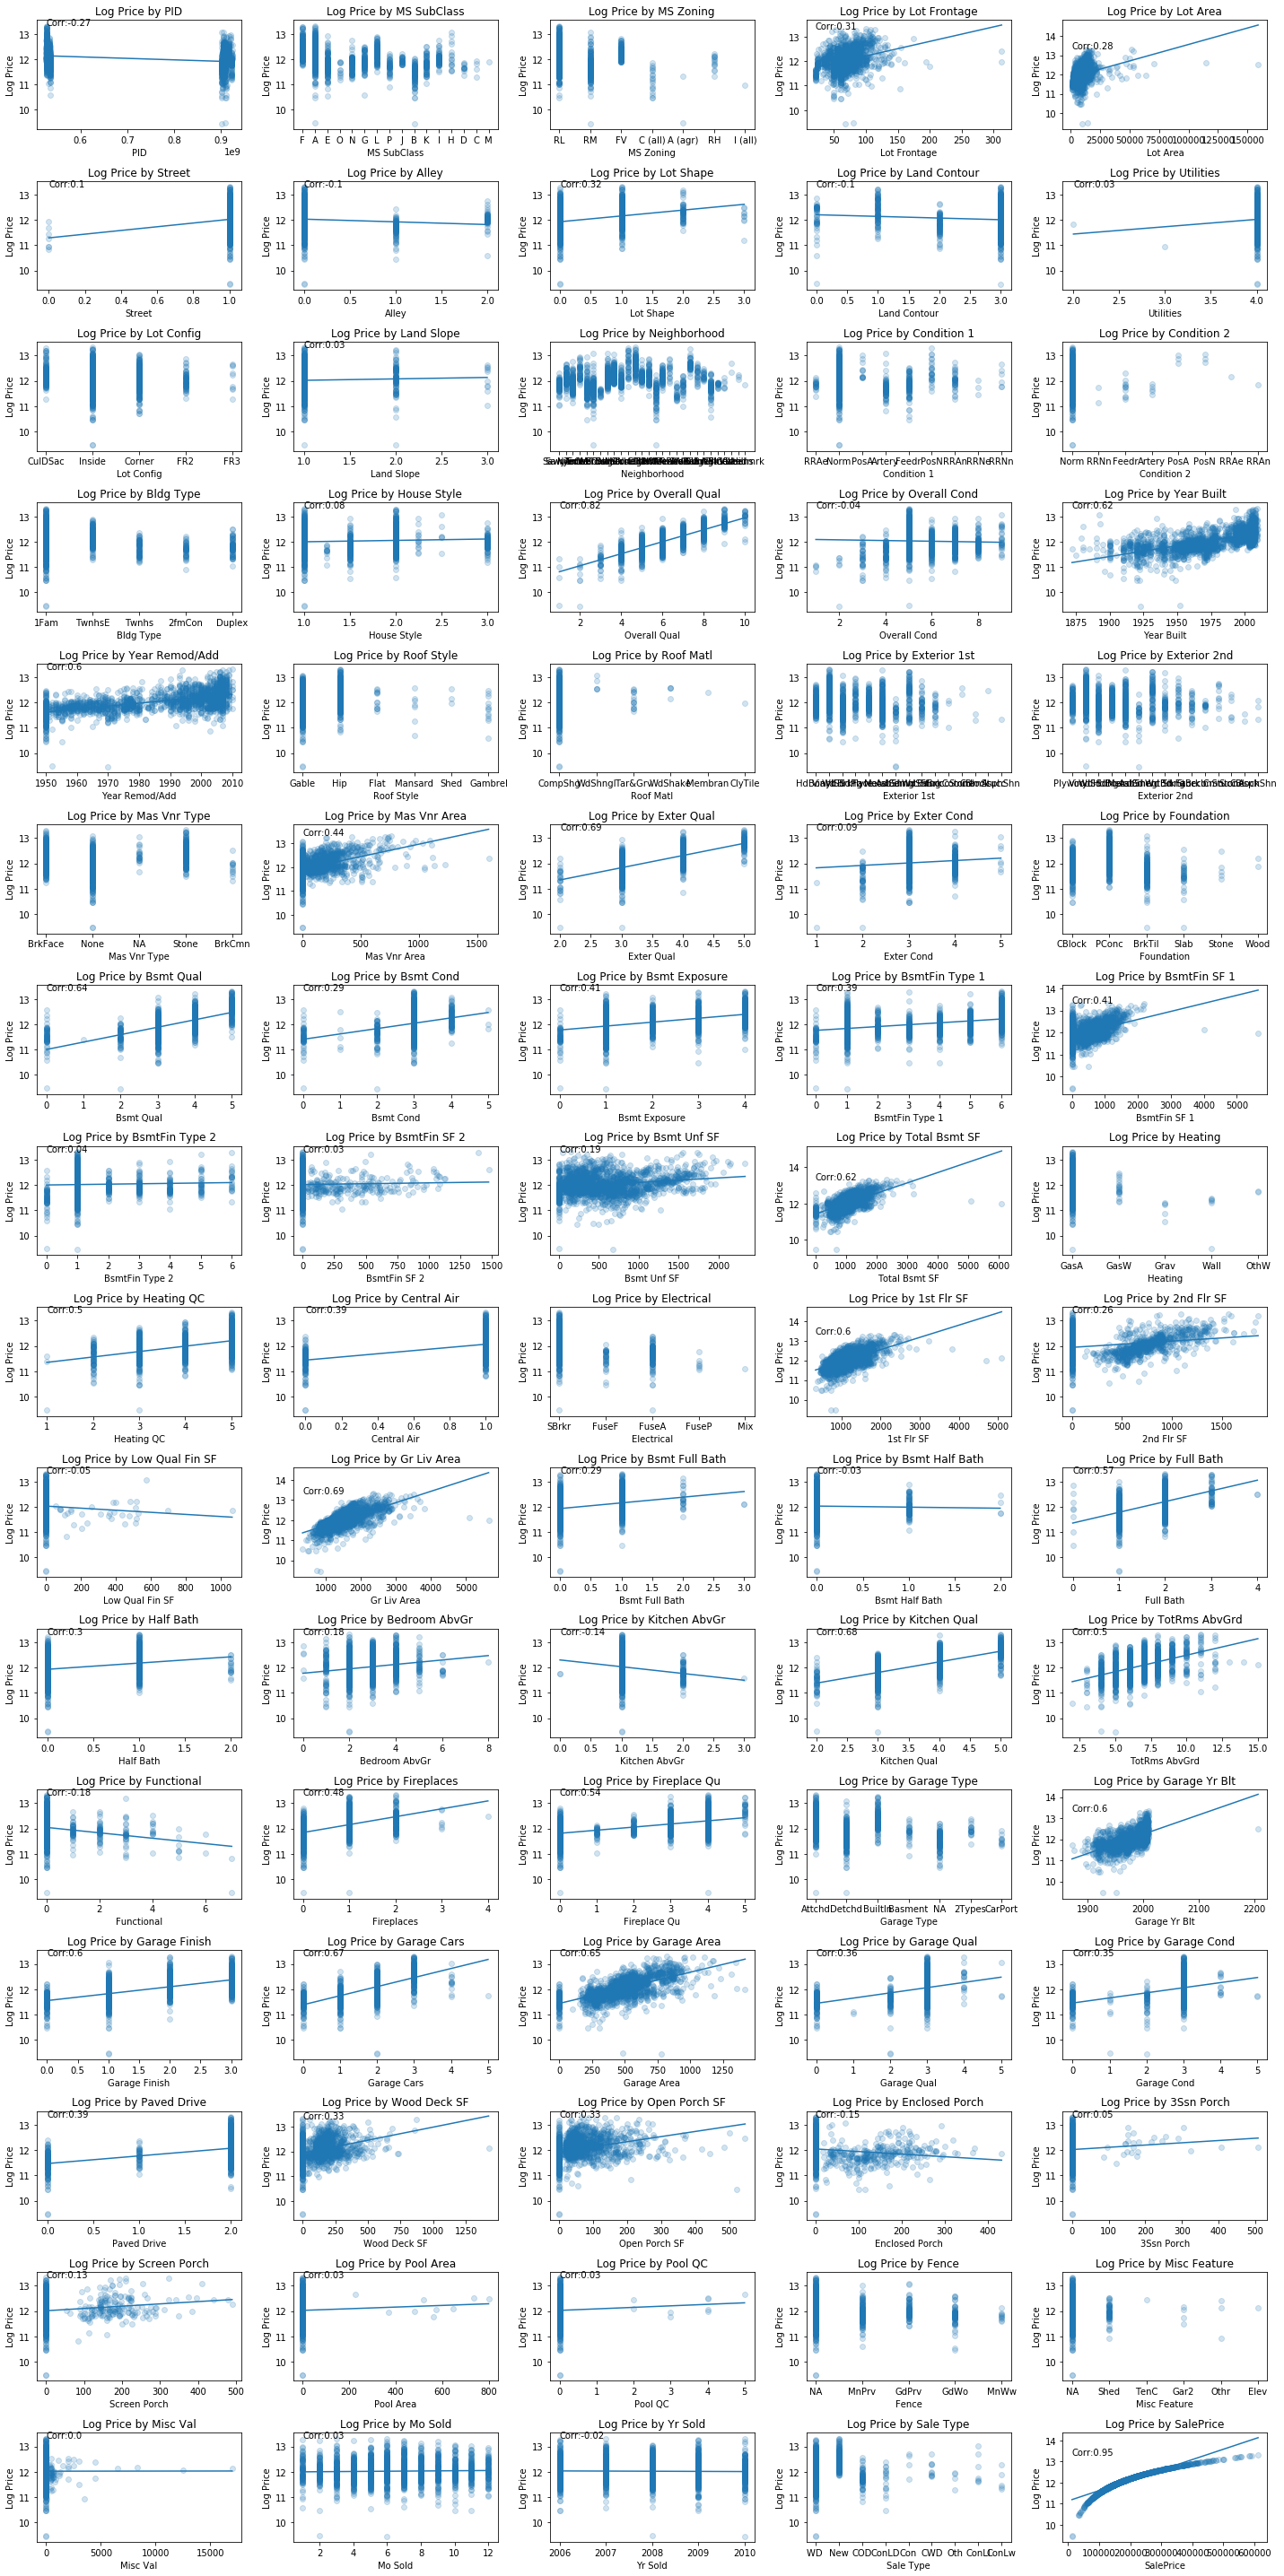

In [9]:
fig, ax = plt.subplots(16, 5, figsize=(20,40))
ax = ax.flatten()

for i, variable in enumerate(housing_train.drop(columns='Log Price').columns):
    scatter_plot(variable, 'Log Price', ax=ax[i])
    
plt.tight_layout()

In [11]:
# Observations:
# - Irrelevant features: PID
# - Poor predictive features: Utilities (not enough data), Street, Lot Shape, Lot Config, Condition 1/2, 
#     House style, Roof style, Roof Matl, Mas Vnr Type, Heating, Low Qual Fin SF, Bmt Half Bath, Kitchen AbvGr,
#     Enclosed porch, 3Ssn porch, Pool Area, Pool QC, Misc Feature, Misc Value, Mo Sold, Yr Sold, 
# - Good predictive features: Lot Frontage, Lot Area, Overall Qual, Year Built, Year Remod/Add, Exter Qual, 
#     Bsmt Qual, Bsmt Cond, Bsmt Exposure, BsmtFin Type 1, Total Bsmt SF, Heating QC, Central Air, 1/2 Flr SF,
#     Gr Liv Area, Bsmt Full Bath, Full Bath, Half Bath, Kitchen Qual, TotRms AbvGrd, Functional, Fireplaces,
#     Fireplace Qu, Garage Yr Blt, Garage Finish, Garage Cars, Garage Area, Garage Qual, Garage Cond, Paved Drive,
#     Wood Deck SF, Open Porch SF, 
# - Unclear numerical relationship, but maybe categorical one: Alley
# - Categorical that need groups: MS Subclass, MS Zoning, Neighborhood, Exterior 1/2, Foundation, Electrical, 
#     Sale Type
# - Outliers: price, Lot Frontage, Lot Area, BsmtSF1, Total Bsmt SF, 1st Flr SF, Gr Liv Area, Wood Deck SF
# - Other: 
#     Perhaps two groups for lot area
#     Overall Cond has a lot of high priced 5's which appears to damage linear relationship
#     Year build may have exponential relationship
#     Year Remod/Add has strange lower bound of 1950
#     Exter Cond has a lot of high priced 3's which appears to damage linear relationship
#     Invalid value for Garage Yr Blt (~2200)

#### Data errors

In [12]:
# error in garage yr blt
select_columns = ['Garage Yr Blt', 'Garage Type', 'Year Built', 'Year Remod/Add', 'Yr Sold','Mo Sold']
housing_train.loc[housing_train['Garage Yr Blt']>2020, select_columns]

,Garage Yr Blt,Garage Type,Year Built,Year Remod/Add,Yr Sold,Mo Sold
Id,,,,,,
2261,2207.0,Attchd,2006,2007,2007,9


In [13]:
# assume this is a typo, and make best guess at correction
housing_train.loc[2261,'Garage Yr Blt'] = 2007

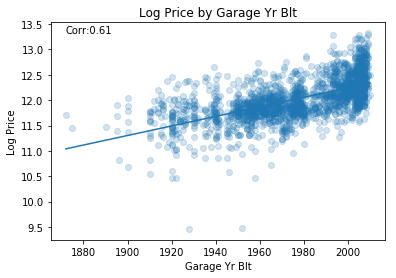

In [14]:
scatter_plot('Garage Yr Blt', 'Log Price', ax=plt.gca())

In [15]:
# check test data for errors
housing_test['Garage Yr Blt'].max()

2010.0

In [16]:
# lower bound on Year Remod/Add
select_columns = ['Year Built', 'Year Remod/Add', 'Garage Yr Blt']
housing_train.loc[housing_train['Year Remod/Add']==1950, select_columns].head(10)

,Year Built,Year Remod/Add,Garage Yr Blt
Id,,,
1311,1916,1950,1916.0
2860,1929,1950,1931.0
1537,1935,1950,1935.0
912,1928,1950,1981.0
1295,1920,1950,1920.0
1360,1930,1950,1930.0
2723,1924,1950,1924.0
1350,1927,1950,1920.0
1993,1910,1950,1920.0


In [17]:
# this seems to be some sort of imputation for missing data - replace with Garage Yr Build
# first making sure this is later that house year build
def clean_year_built(df):
    condition_1 = df['Year Remod/Add']==1950
    condition_2 = df['Year Built'] > df['Garage Yr Blt']
    
    df.loc[condition_1 & condition_2, 'Garage Yr Blt'] = df['Year Built']
    df.loc[condition_1, 'Year Remod/Add'] = df['Garage Yr Blt']
    
    return df

In [18]:
housing_train = clean_year_built(housing_train)

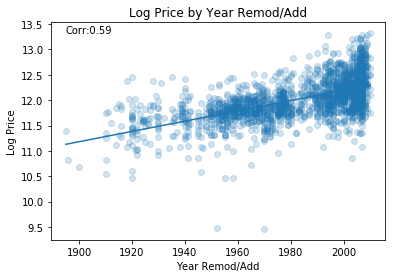

In [19]:
scatter_plot('Year Remod/Add', 'Log Price', ax=plt.gca())

In [20]:
# clean test data
housing_test = clean_year_built(housing_test)

#### Outliers

In [21]:
# price
housing_train.drop(housing_train[housing_train['Log Price']<10].index, inplace=True)

In [22]:
# lot frontage 250

In [23]:
# lot area 100,000

In [24]:
# Gr Liv Area 4000
# BsmtSF1, Total Bsmt SF, 1st Flr SF

In [25]:
# Wood Deck 1000

### Ranking feature importance

#### Using correlations

In [26]:
feature_importance_corr = abs(housing_train.drop(columns=['PID']).corr()['Log Price']).sort_values(ascending=False)

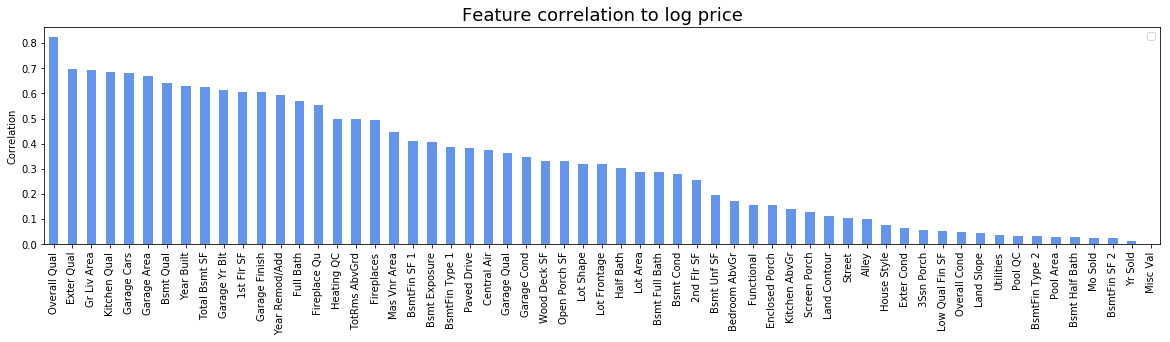

In [27]:
# plot feature importance
fig, ax = plt.subplots(figsize=(20,4))
feature_importance_corr[2:].plot.bar(color='cornflowerblue', ax=ax)
ax.set_title('Feature correlation to log price', fontsize=18)
ax.set_ylabel('Correlation')
ax.legend('');

#### Using a random forest

In [28]:
## ranking features helps to know where to focus efforts on feature engineering and selection
## correlations are important, but don't work for categories
## H20 random forest allows analysis of important features across categorical variables also

In [29]:
# connect to h2o by running in terminal:
# import h2o
# h2o.init()
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,13 days 6 hours 55 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.9
H2O cluster version age:,30 days
H2O cluster name:,H2O_from_python_emmalowe_w2bimz
H2O cluster total nodes:,1
H2O cluster free memory:,1.595 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [30]:
## the analysis above is useful, but only incorporates numerical variables
## H20 random forest allows analysis of important features across categorical variables also

In [31]:
# load dataframe into h2o frame
housing_train_h2oframe = h2o.H2OFrame(housing_train)

/anaconda3/envs/dsi/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [32]:
# build and train model
feature_columns = list(housing_train.drop(columns=['PID', 'SalePrice', 'Log Price']).columns)
rf = h2o.estimators.H2ORandomForestEstimator()
rf.train(x=feature_columns, y='Log Price', training_frame=housing_train_h2oframe)

drf Model Build progress: |███████████████████████████████████████████████| 100%


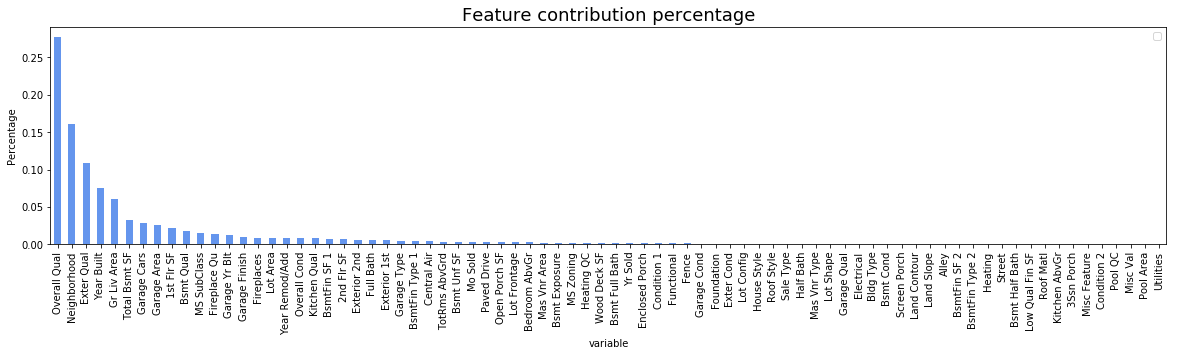

In [33]:
# get and plot feature importance
feature_importance_rf = rf._model_json['output']['variable_importances'].as_data_frame()
feature_importance_rf.set_index('variable', inplace = True)

fig, ax = plt.subplots(figsize=(20,4))
feature_importance_rf.plot.bar(use_index=True, y ='percentage', color='cornflowerblue', ax=ax)
ax.set_title('Feature contribution percentage', fontsize=18)
ax.set_ylabel('Percentage')
ax.legend('');

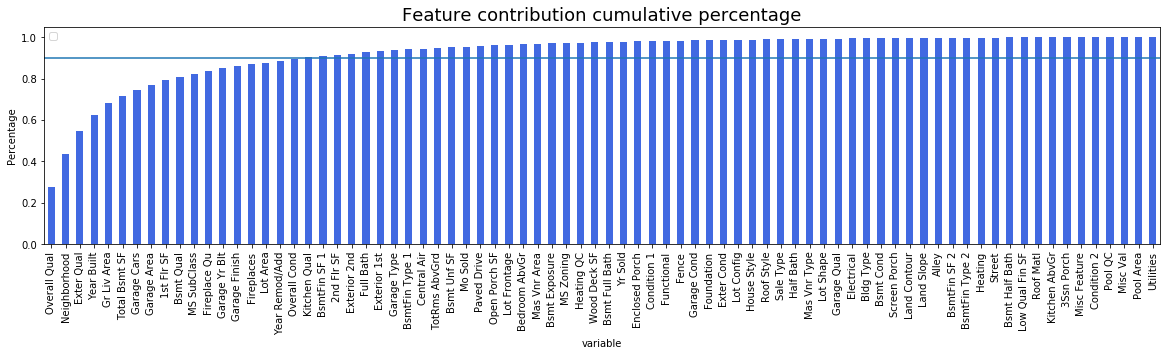

In [34]:
feature_importance_rf['cum_percentage'] = np.cumsum(feature_importance_rf['percentage'])
fig, ax = plt.subplots(figsize=(20,4))
feature_importance_rf.plot.bar(use_index=True, y ='cum_percentage', color='royalblue', ax=ax)
ax.set_title('Feature contribution cumulative percentage', fontsize=18)
ax.set_ylabel('Percentage')
ax.legend('');
plt.axhline(y = 0.9);

#### Relationship between the two measures

In [35]:
feature_importance_comb = pd.DataFrame(feature_importance_corr[2:])
feature_importance_comb.columns = ['corr']
feature_importance_comb['rf_perc'] = [feature_importance_rf.loc[idx,'percentage'] for idx in feature_importance_comb.index]

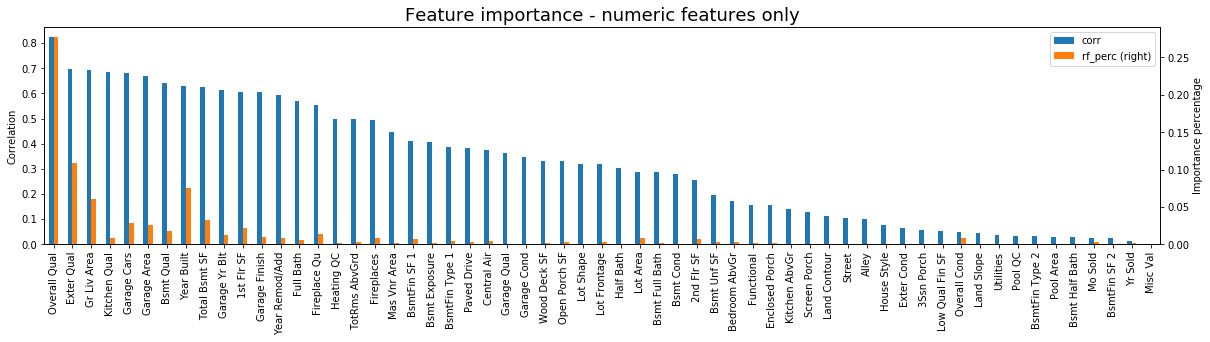

In [36]:
# plot feature importance
fig, ax = plt.subplots(figsize=(20,4))

feature_importance_comb.plot(kind='bar', ax=ax, secondary_y='rf_perc')

ax.set_title('Feature importance - numeric features only', fontsize=18)
ax.set_ylabel('Correlation')
ax.right_ax.set_ylabel('Importance percentage');

In [37]:
## similar pattern between the two measures

In [38]:
# shouldn't forget that correlations can't capture important categorical features
features_non_numeric = [feature for feature in feature_importance_rf.index if feature not in feature_importance_corr.index]

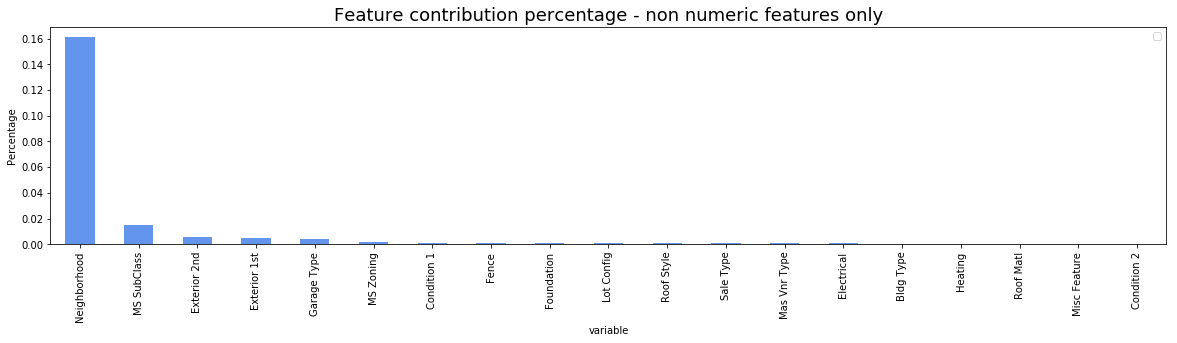

In [39]:
# get and plot feature importance
fig, ax = plt.subplots(figsize=(20,4))
feature_importance_rf.loc[features_non_numeric,:].plot.bar(use_index=True, y ='percentage', color='cornflowerblue', ax=ax)
ax.set_title('Feature contribution percentage - non numeric features only', fontsize=18)
ax.set_ylabel('Percentage')
ax.legend('');

## 3. Feature engineering

In [40]:
feature_importance_rf[feature_importance_rf['cum_percentage']<0.9]

,relative_importance,scaled_importance,percentage,cum_percentage
variable,,,,
Overall Qual,3631.312988,1.000000,0.277069,0.277069
Neighborhood,2109.537109,0.580930,0.160958,0.438026
Exter Qual,1423.827148,0.392097,0.108638,0.546664
Year Built,994.999634,0.274005,0.075918,0.622583
Gr Liv Area,786.508606,0.216591,0.060011,0.682593
Total Bsmt SF,432.641388,0.119142,0.033011,0.715604
Garage Cars,368.082428,0.101363,0.028085,0.743688
Garage Area,341.965424,0.094171,0.026092,0.769780
1st Flr SF,281.165649,0.077428,0.021453,0.791233


In [41]:
## observations:
## - a quarter of variables explain 90% of variation in the model
## - important categorical data include Neighborhood and MS SubClass
## - quality and size seem to be important numerical features

### New features

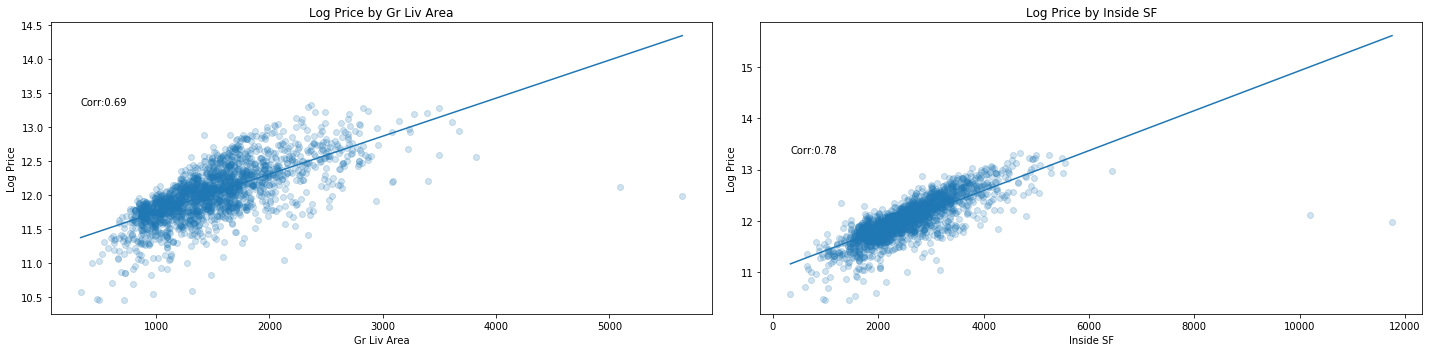

In [42]:
# SF features

# inside SF
inside_SF_columns = ['Total Bsmt SF', '1st Flr SF', '2nd Flr SF']
housing_train['Inside SF'] = housing_train[inside_SF_columns].sum(axis=1)

select_columns = ['Gr Liv Area', 'Inside SF']

fig, ax = plt.subplots(1, 2, figsize=(20,5))
for i, variable in enumerate(select_columns):
    scatter_plot(variable, 'Log Price', ax=ax[i])  
plt.tight_layout()

In [43]:
## New feature seems to be a better predictor
housing_test['Inside SF'] = housing_test[inside_SF_columns].sum(axis=1)

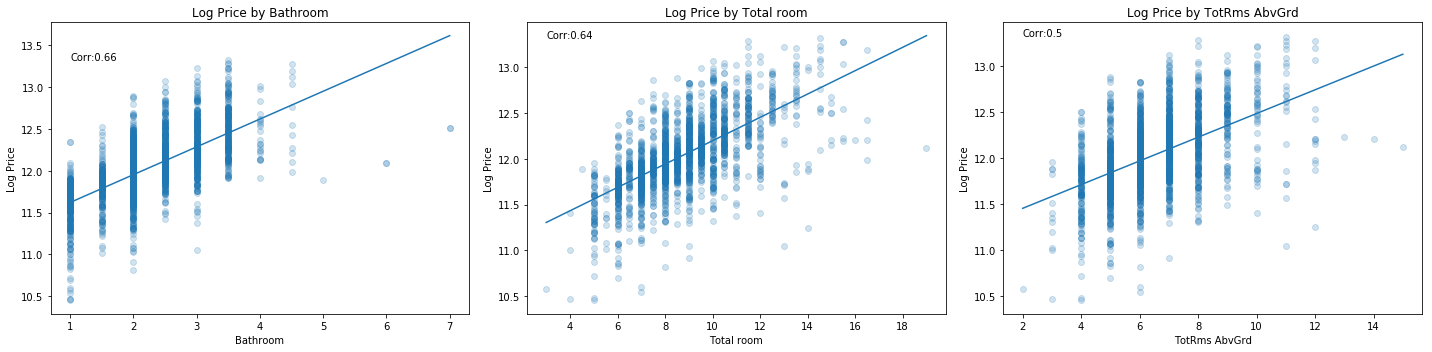

In [44]:
# num rooms

# total bathrooms
housing_train['Bathroom'] = housing_train['Full Bath'] + housing_train['Half Bath']/2 + housing_train['Bsmt Full Bath'] + housing_train['Bsmt Half Bath']/2

# total rooms
housing_train['Total room'] = housing_train['Bathroom'] + housing_train['TotRms AbvGrd']

select_columns = ['Bathroom', 'Total room', 'TotRms AbvGrd']

fig, ax = plt.subplots(1, 3, figsize=(20,5))
for i, variable in enumerate(select_columns):
    scatter_plot(variable, 'Log Price', ax=ax[i])  
plt.tight_layout()


In [45]:
## New features seem to be good predictors
housing_test['Bathroom'] = housing_test['Full Bath'] + housing_test['Half Bath']/2 + housing_test['Bsmt Full Bath'] + housing_test['Bsmt Half Bath']/2
housing_test['Total room'] = housing_test['Bathroom'] + housing_test['TotRms AbvGrd']

### Categorical groupings

In [46]:
## some categories have few data points, so it might be worth grouping some categories

In [47]:
# Neighborhood

In [48]:
# MS Subclass

### Transforms

In [50]:
def check_log_transform(variable):
    correlation = np.corrcoef((housing_train[variable]), housing_train['Log Price'])[0,1]
    transform_correlation = np.corrcoef(np.log(housing_train[variable]), housing_train['Log Price'])[0,1]
    print('Correlation between '+variable+' and Log Price: ', correlation) 
    print('Correlation between Log '+variable+' and Log Price: ', transform_correlation)

In [51]:
# check whether tranform on Year Built would improve correlation
check_log_transform('Year Built')

Correlation between Year Built and Log Price:  0.6300072273793981
Correlation between Log Year Built and Log Price:  0.6280866920059284


In [52]:
# check whether tranform on Garage Yr Blt Built would improve correlation
check_log_transform('Garage Yr Blt')

Correlation between Garage Yr Blt and Log Price:  0.6128408905668673
Correlation between Log Garage Yr Blt and Log Price:  0.611529187064086


In [53]:
# check whether tranform on Year Remod/Add would improve correlation
check_log_transform('Year Remod/Add')

Correlation between Year Remod/Add and Log Price:  0.5945184457594074
Correlation between Log Year Remod/Add and Log Price:  0.5939105383353601


In [54]:
## all untransformed variables have stronger correlation with Log Price than transformed counterpart
## therefore no feature engineering is needed

## 4. Feature selection

### Collinearity

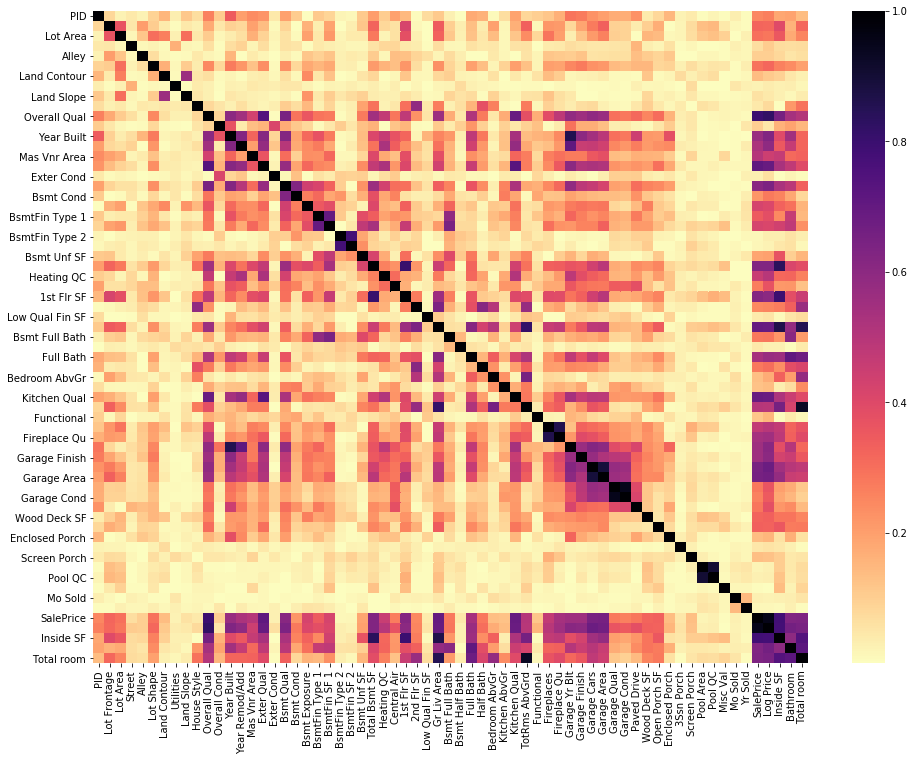

In [55]:
# plot heatmap
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(abs(housing_train.corr()), cmap='magma_r');

In [56]:
## some strong multicollinearity between variables (e.g. Garage Cars and Garage Area)


###  Unimportant features

In [61]:
feature_importance_rf.tail(20)

,relative_importance,scaled_importance,percentage,cum_percentage
variable,,,,
Bsmt Cond,7.950758,0.002189,0.000607,0.995197
Screen Porch,7.272812,0.002003,0.000555,0.995752
Land Contour,7.046785,0.001941,0.000538,0.996290
Land Slope,6.987752,0.001924,0.000533,0.996823
Alley,5.326395,0.001467,0.000406,0.997229
BsmtFin SF 2,5.087312,0.001401,0.000388,0.997618
BsmtFin Type 2,4.592863,0.001265,0.000350,0.997968
Heating,4.208589,0.001159,0.000321,0.998289
Street,4.157193,0.001145,0.000317,0.998606


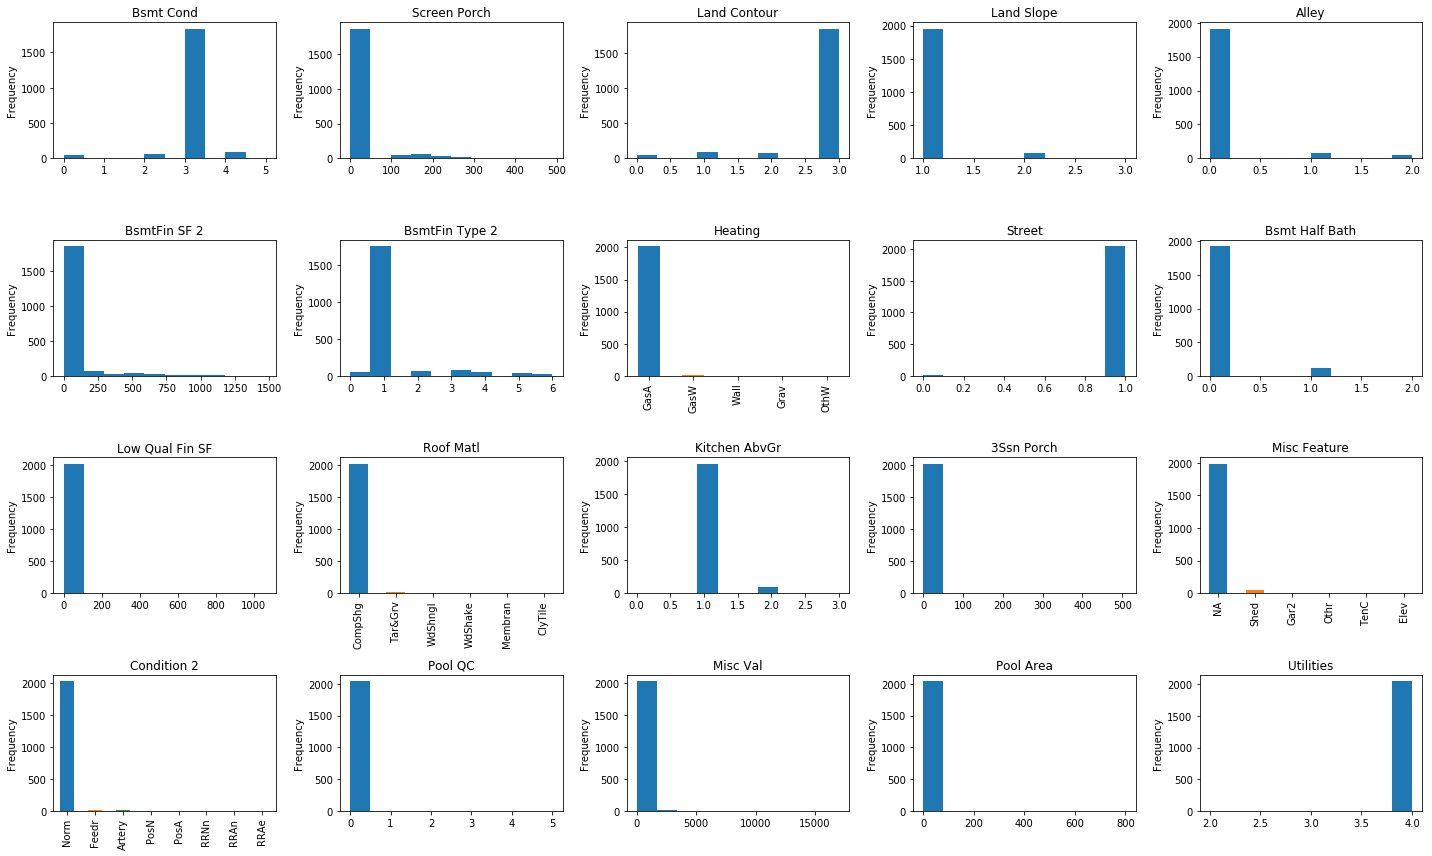

In [60]:
fig, ax = plt.subplots(4, 5, figsize=(20,12))
ax = ax.flatten()

for i, variable in enumerate(feature_importance_rf.tail(20).index):
    try:
        housing_train[variable].plot.hist(ax=ax[i])
    except:
        housing_train[variable].value_counts().plot.bar(ax=ax[i])
    ax[i].set_title(variable)
    ax[i].set_ylabel('Frequency')
    
plt.tight_layout()

In [ ]:
## most low importance features are heavily dominated by one category
## linear regression on categories that have a low number of points is likely to lead to overfitting